In [6]:
import pandas as pd

In [7]:
csv_file = open("uaScoresDataFrame.csv")
scores = pd.read_csv(csv_file)
scores = scores.drop('id', axis=1)
scores = scores.drop('Venture Capital', axis=1)

In [8]:
def check_zero(dataset):
    invalid_rows = []
    for element in dataset.columns.tolist():
        invalid = dataset[dataset[element] == 0.0]
        invalid_rows.append(invalid[['UA_Name','UA_Country']])
    df = pd.concat(invalid_rows).reset_index(drop=True).value_counts()
    return df
results = check_zero(scores).to_frame().reset_index().rename(columns={0:"number"})
print(results)

                       UA_Name               UA_Country  number
0                      Andorra                  Andorra       6
1                    Gibraltar                Gibraltar       5
2                      Managua                Nicaragua       3
3                     Tashkent               Uzbekistan       3
4                  Belize City                   Belize       3
5                       Panama                   Panama       3
6                    Palo Alto               California       2
7                       La Paz                  Bolivia       2
8                     Portland                    Maine       2
9                       Havana                     Cuba       2
10                     Fukuoka                    Japan       2
11                    San Juan              Puerto Rico       2
12                     Bozeman                  Montana       2
13                   Baltimore                 Maryland       2
14                    Valletta          

In [9]:
scores = scores[(scores != 0).all(1)]

In [10]:
weights_data = {
    'Housing' : 1.5,
    'Cost of Living' : 1.5,
    'Startups' : 0.5,
    'Business Freedom' : 0.8,
    'Safety' : 1.5,
    'Healthcare' : 1.5,
    'Education' : 0.5,
    'Travel Connectivity' : 1.5,
}

weights_vector = pd.Series(0.0, index=scores.columns[3:-1])
for i in range(len(weights_vector)):
    row_name = weights_vector.index[i]
    weights_vector[i] = weights_data.get(row_name, 1)

In [11]:
summable_values = list(scores)
if 'Naive Sum' in summable_values:
    summable_values.remove('Naive Sum')
weighted_scores = scores.copy()
weighted_scores = weighted_scores * weights_vector
scores['Naive Sum'] = weighted_scores[summable_values].sum(numeric_only=True, axis=1)

In [33]:
# scores['Naive Sum']
# better, worse

midpoint = scores['Naive Sum'].quantile()
scores['Label'] = ''
scores.loc[scores['Naive Sum'] < midpoint, 'Label'] = 'worse'
scores.loc[scores['Naive Sum'] >= midpoint, 'Label'] = 'better'

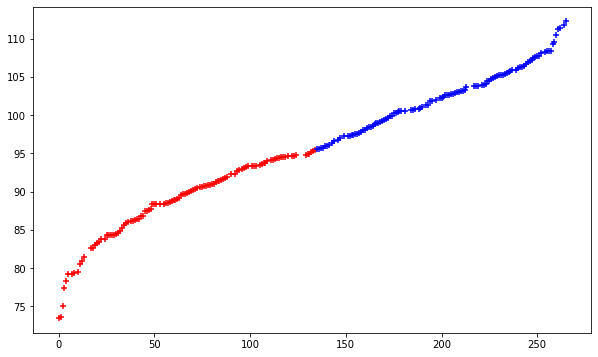

In [42]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
vals = scores['Naive Sum'].sort_values()
color = np.where(vals >= midpoint, 'b', 'r')
ax.scatter(scores.index, vals, c=color, marker='+')

In [45]:
from Modules.dataprocessing import ProcessingData

a, b = ProcessingData.prepare_data(scores)

pd.concat([a.head(), b.head()])

,UA_Name,UA_Country,UA_Continent,Housing,Cost of Living,Startups,Travel Connectivity,Commute,Business Freedom,Safety,...,Education,Environmental Quality,Economy,Taxation,Internet Access,Leisure & Culture,Tolerance,Outdoors,Naive Sum,Label
0,Edinburgh,United Kingdom,Europe,0.538333,0.457111,0.345444,0.483203,0.871702,0.860368,0.824987,...,0.607154,0.760510,0.512971,0.528167,0.479061,0.688944,0.778759,0.623032,0.877156,better
1,Istanbul,Turkey,Asia,0.904167,0.865222,0.661500,0.553021,0.551083,0.438750,0.641137,...,0.179405,0.258884,0.347280,0.337940,0.286886,1.000000,0.287985,0.705435,0.653933,better
2,Vancouver,Canada,North America,0.342278,0.473222,0.796667,0.224106,0.697926,0.856767,0.719228,...,0.693627,0.836503,0.562573,0.682120,0.407354,0.524111,0.824189,0.928293,0.717996,better
3,Zagreb,Croatia,Europe,0.878889,0.688222,0.383667,0.144360,0.679929,0.407166,0.844914,...,0.294322,0.710845,0.118430,0.765979,0.462770,0.443833,0.782717,0.579712,0.680578,better
4,Denver,Colorado,North America,0.315278,0.455778,0.762722,0.382097,0.629352,0.815902,0.465257,...,0.339214,0.686128,0.645634,0.340564,0.506941,0.580389,0.771268,1.000000,0.473892,worse
188,Louisville,Kentucky,North America,0.695333,0.595333,0.361556,0.084791,0.195060,0.815902,0.262693,...,0.339214,0.626795,0.645634,0.307441,0.519390,0.521500,0.517691,0.107628,0.279379,worse
189,Guadalajara,Mexico,North America,0.947444,0.943333,0.371611,0.112322,0.598247,0.413354,0.592445,...,0.077027,0.251806,0.274201,0.339107,0.354807,0.739667,0.807442,0.400444,0.534404,worse
190,Brussels,Belgium,Europe,0.595000,0.386333,0.521278,0.728185,0.773792,0.844438,0.619130,...,0.668006,0.395419,0.435763,0.053301,0.753958,0.793778,0.603252,0.487421,0.732634,better
192,Toronto,Canada,North America,0.406667,0.474556,0.997889,0.391972,0.655146,0.856767,0.733553,...,0.771089,0.693120,0.562573,0.682120,0.388137,0.758444,0.779490,0.685322,0.841679,better
193,Johannesburg,South Africa,Africa,0.779111,0.730556,0.437500,0.270473,0.525794,0.270259,0.441518,...,0.028064,0.364861,0.183930,0.434453,0.210819,0.377944,0.259728,0.330418,0.041828,worse
